In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")


Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/monumentimagenotaugmented/"
x = load(os.path.join(path, 'train/Train_21.jpg'))
print(x.shape)

(300, 300, 3)


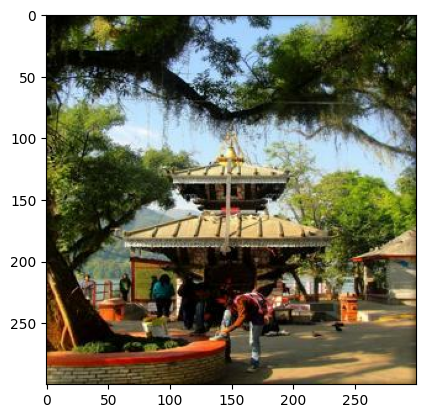

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

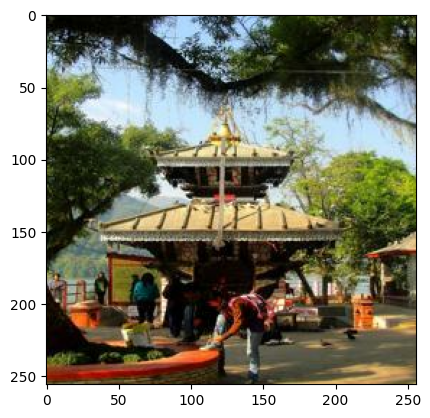

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

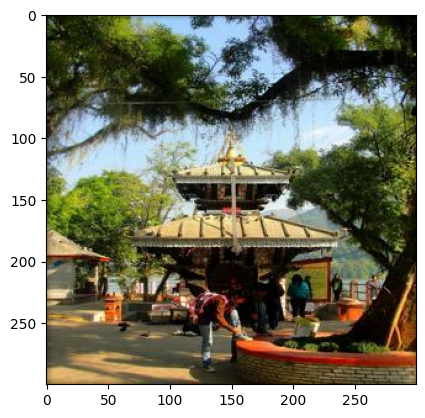

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [16]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [18]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [19]:
test_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
# downsample block
def downsample(filters, size, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())

    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 150, 150, 3)


In [21]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 300, 300, 3)


In [22]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]


    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

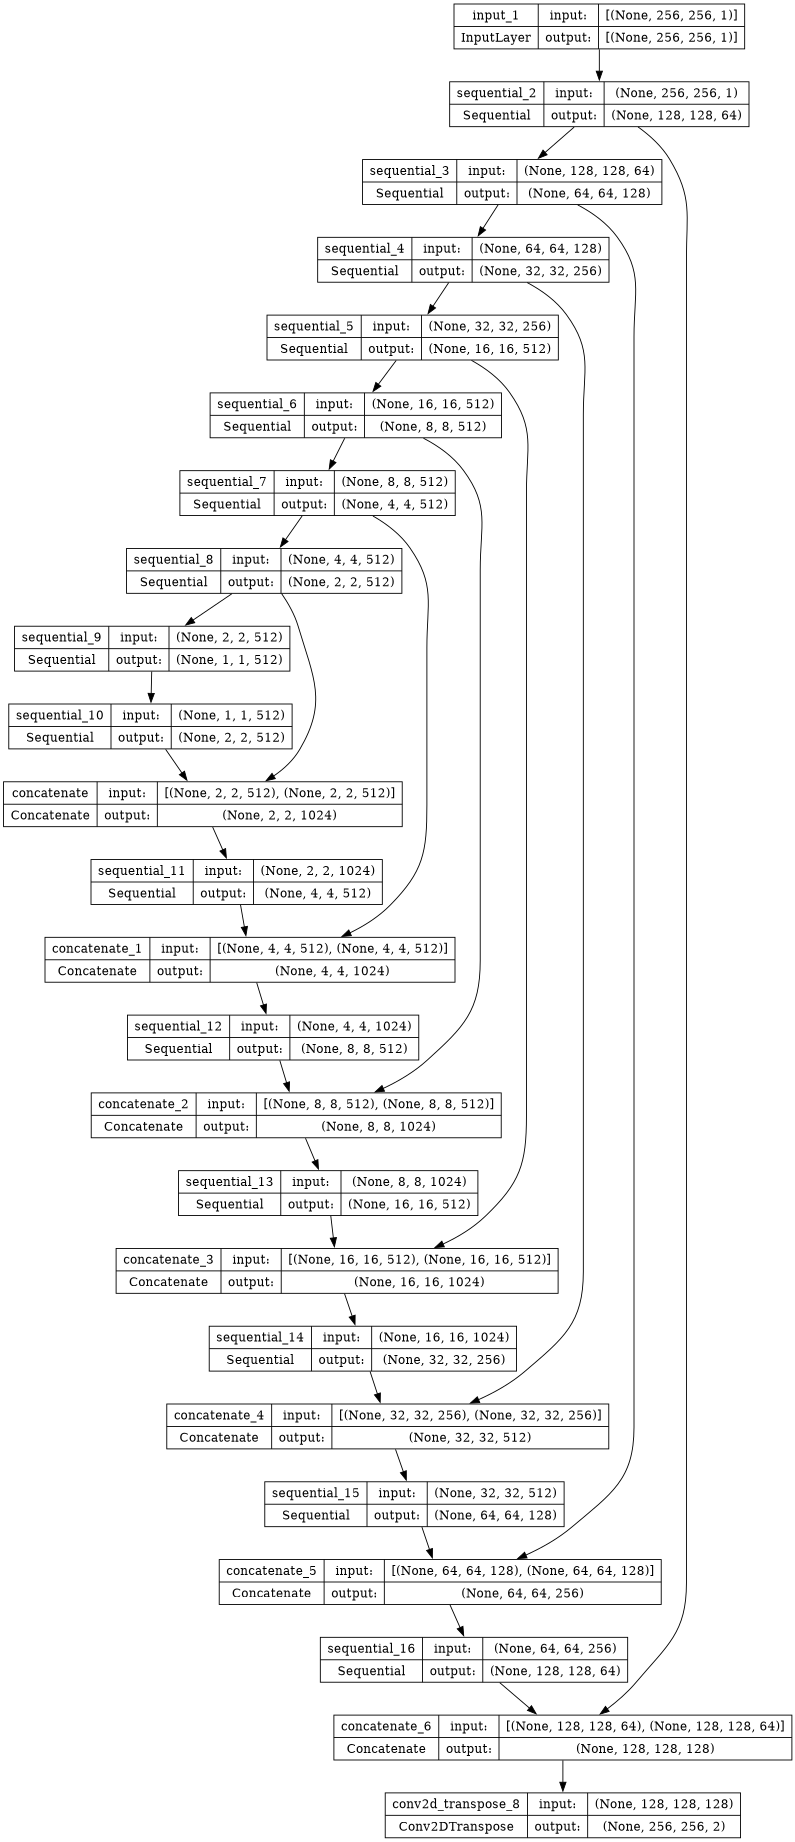

In [23]:
gen = generator()
plot_model(gen, show_shapes=True, dpi = 64)

In [24]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

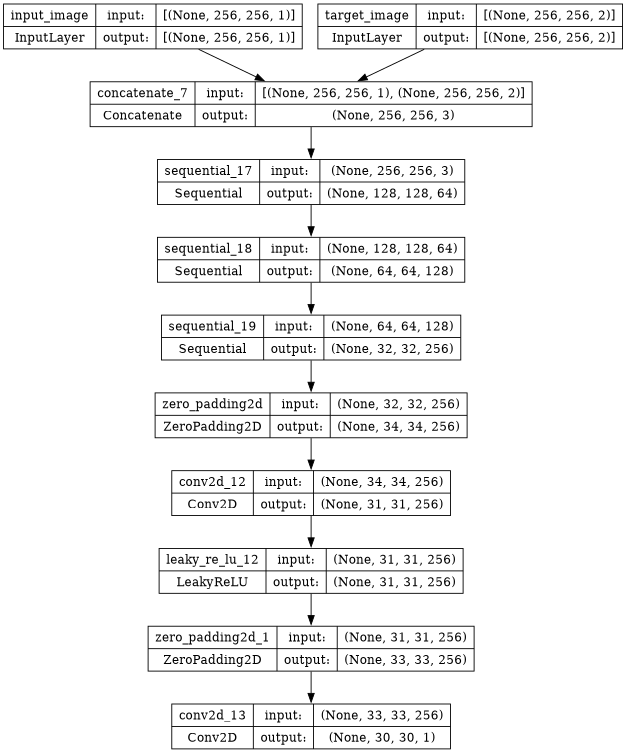

In [25]:
disc = discriminator()
plot_model(disc, show_shapes=True, dpi = 64)

In [26]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [27]:
LAMBDA = 100

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [29]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [31]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [32]:
epochs = 200

In [33]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

        ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        if epoch > 10:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values

In [34]:
@tf.function
def test_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

    ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values


In [35]:
def display_one_random_test_image(input_, target, gen_model):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title('Generated Output')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))

In [36]:
def display_random_test_image(test_ds, gen_model):
    # Shuffle the dataset and take one batch
    random_test_batch = test_ds.shuffle(buffer_size=len(test_ds)).take(1)

    # Extract input and target from the batch
    random_test_input, random_test_target = list(random_test_batch)[0]

    # Display the image
    display_one_random_test_image(tf.reshape(random_test_input[0], (1,256,256,1)),tf.reshape(random_test_target[0],(1,256,256,2)), gen_model)


Displaying one random test image...


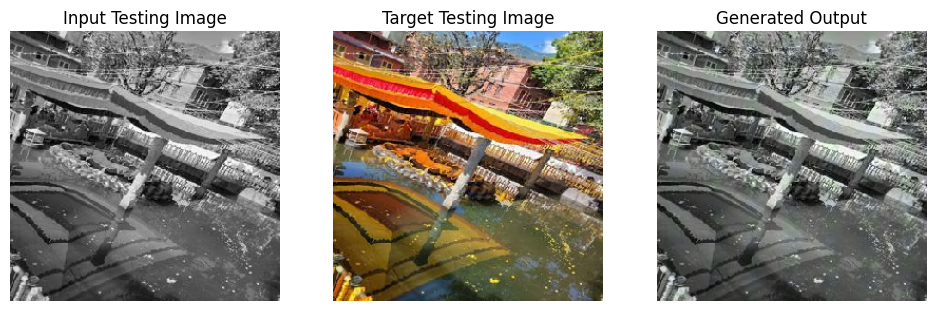

SSIM Score: 0.855381965637207
PSNR Score: 16.722942352294922


In [37]:
display_random_test_image(test_dataset, gen)

In [38]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
testing_ssim = []
testing_psnr = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_gan_losses, test_generator_l1_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate

    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            train_count += 1
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.2f} gan_loss:{:.2f} l1_loss:{:.2f} Discriminator-- total_loss:{:.2f} real_loss:{:.2f} generated_loss:{:.2f} --- SSIM {:.2f} PSNR {:.2f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print("Number of iteration {d}", train_count)

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr = test_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
        print("Testing Details")
        print("Generator-- total_loss:{:.2f} gan_loss:{:.2f} l1_loss:{:.2f} Discriminator-- total_loss:{:.2f} real_loss:{:.2f} generated_loss:{:.2f} --- SSIM {:.2f} PSNR {:.2f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print("Number of iteration {d}", test_count)

        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        if epoch == 0 or epoch % 10 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(test_dataset, gen_model)

        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.2, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.5, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [39]:
tf.config.run_functions_eagerly(True)

Epoch 0
Training Details
Generator-- total_loss:5.35 gan_loss:0.96 l1_loss:0.04 Discriminator-- total_loss:1.40 real_loss:0.69 generated_loss:0.71 --- SSIM 0.89 PSNR 23.06
Time taken for epoch 1 is 170.40518879890442 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:7.79 gan_loss:0.95 l1_loss:0.07 Discriminator-- total_loss:1.74 real_loss:0.52 generated_loss:1.22 --- SSIM 0.88 PSNR 20.07
Time taken for epoch 1 is 184.3403549194336 sec
Number of iteration {d} 70
Displaying one random test image...


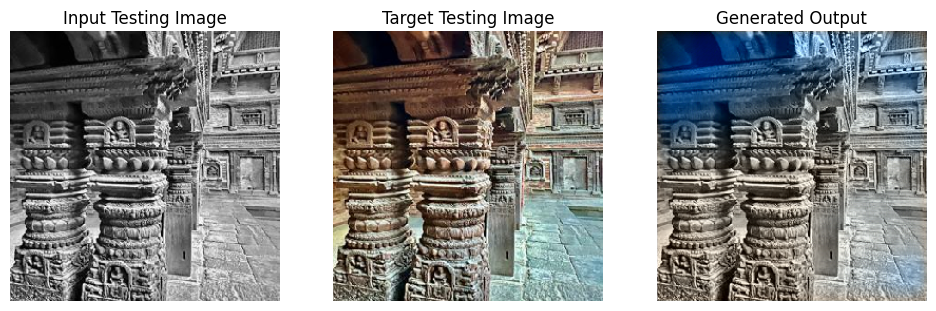

SSIM Score: 0.9096539616584778
PSNR Score: 19.525630950927734
Epoch 1
Training Details
Generator-- total_loss:4.84 gan_loss:0.97 l1_loss:0.04 Discriminator-- total_loss:1.60 real_loss:0.82 generated_loss:0.78 --- SSIM 0.93 PSNR 23.83
Time taken for epoch 2 is 164.61087107658386 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:7.61 gan_loss:0.48 l1_loss:0.07 Discriminator-- total_loss:1.57 real_loss:1.19 generated_loss:0.38 --- SSIM 0.89 PSNR 19.86
Time taken for epoch 2 is 177.54081344604492 sec
Number of iteration {d} 70
Epoch 2
Training Details
Generator-- total_loss:4.69 gan_loss:0.89 l1_loss:0.04 Discriminator-- total_loss:1.33 real_loss:0.67 generated_loss:0.66 --- SSIM 0.94 PSNR 23.89
Time taken for epoch 3 is 164.45937943458557 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:5.95 gan_loss:0.45 l1_loss:0.05 Discriminator-- total_loss:1.71 real_loss:1.17 generated_loss:0.54 --- SSIM 0.93 PSNR 21.61
Time taken for epoch 3 is 177.53055691

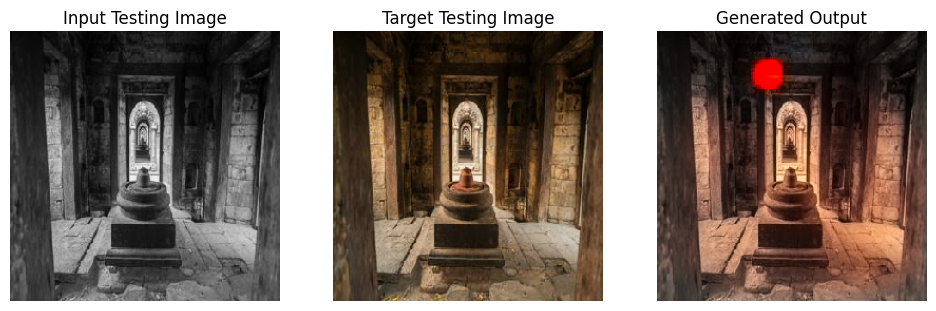

SSIM Score: 0.9293520450592041
PSNR Score: 18.503082275390625
Epoch 11
Training Details
Generator-- total_loss:6.97 gan_loss:2.98 l1_loss:0.04 Discriminator-- total_loss:0.61 real_loss:0.29 generated_loss:0.31 --- SSIM 0.94 PSNR 23.33
Time taken for epoch 12 is 111.08984398841858 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:4.79 gan_loss:0.27 l1_loss:0.05 Discriminator-- total_loss:1.93 real_loss:1.81 generated_loss:0.11 --- SSIM 0.94 PSNR 22.76
Time taken for epoch 12 is 123.90200877189636 sec
Number of iteration {d} 70
Epoch 12
Training Details
Generator-- total_loss:11.24 gan_loss:7.26 l1_loss:0.04 Discriminator-- total_loss:0.02 real_loss:0.01 generated_loss:0.01 --- SSIM 0.94 PSNR 23.36
Time taken for epoch 13 is 110.64695048332214 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:4.58 gan_loss:0.04 l1_loss:0.05 Discriminator-- total_loss:4.37 real_loss:4.34 generated_loss:0.03 --- SSIM 0.94 PSNR 22.73
Time taken for epoch 13 is 123.4

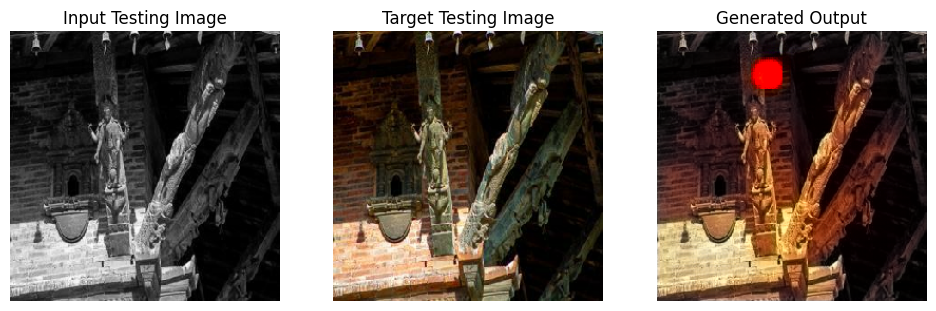

SSIM Score: 0.8352634906768799
PSNR Score: 17.558258056640625
Reduced generator learning rate to 0.00020000000949949026 at epoch 21
Epoch 21
Training Details
Generator-- total_loss:3.35 gan_loss:0.05 l1_loss:0.03 Discriminator-- total_loss:15.49 real_loss:15.49 generated_loss:0.00 --- SSIM 0.95 PSNR 25.09
Time taken for epoch 22 is 102.27900671958923 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:4.43 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:14.43 real_loss:14.43 generated_loss:0.00 --- SSIM 0.95 PSNR 23.48
Time taken for epoch 22 is 115.15545058250427 sec
Number of iteration {d} 70
Epoch 22
Training Details
Generator-- total_loss:3.20 gan_loss:0.00 l1_loss:0.03 Discriminator-- total_loss:15.90 real_loss:15.90 generated_loss:0.00 --- SSIM 0.96 PSNR 25.55
Time taken for epoch 23 is 102.39633965492249 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.75 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:16.25 real_loss:16.25 

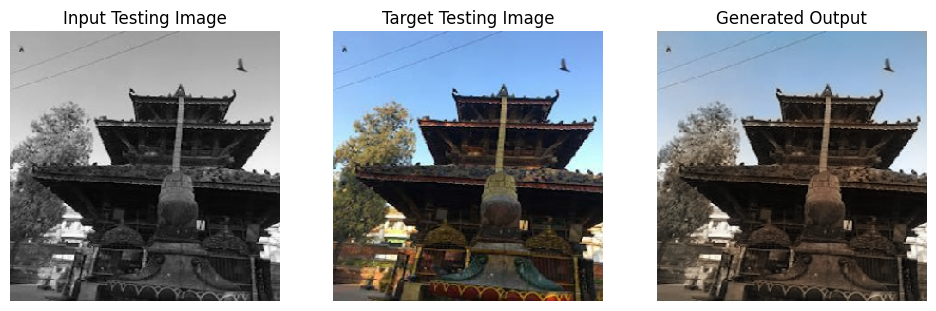

SSIM Score: 0.9661332964897156
PSNR Score: 25.135269165039062
Epoch 31
Training Details
Generator-- total_loss:13.33 gan_loss:10.24 l1_loss:0.03 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.96 PSNR 25.84
Time taken for epoch 32 is 111.68446493148804 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.59 gan_loss:0.02 l1_loss:0.04 Discriminator-- total_loss:5.14 real_loss:5.12 generated_loss:0.02 --- SSIM 0.95 PSNR 25.07
Time taken for epoch 32 is 124.61504912376404 sec
Number of iteration {d} 70
Epoch 32
Training Details
Generator-- total_loss:13.89 gan_loss:10.81 l1_loss:0.03 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.96 PSNR 25.84
Time taken for epoch 33 is 111.00713086128235 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.58 gan_loss:0.01 l1_loss:0.04 Discriminator-- total_loss:5.45 real_loss:5.43 generated_loss:0.01 --- SSIM 0.95 PSNR 25.07
Time taken for epoch 33 is 12

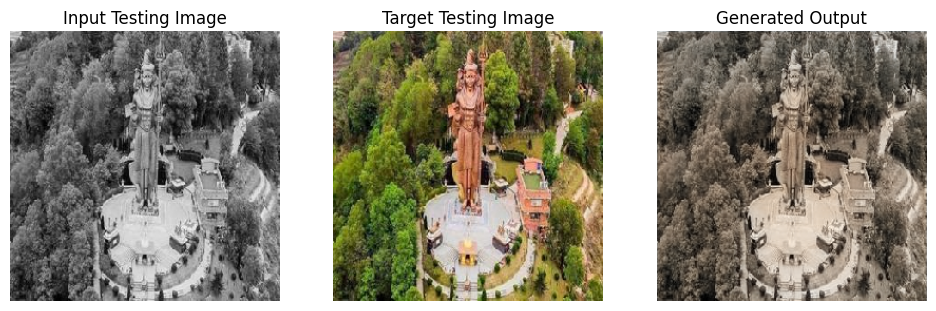

SSIM Score: 0.9333540797233582
PSNR Score: 21.168123245239258
Reduced discriminator learning rate to 0.0002500000118743628 at epoch 41.
Epoch 41
Training Details
Generator-- total_loss:8.74 gan_loss:5.71 l1_loss:0.03 Discriminator-- total_loss:0.14 real_loss:0.08 generated_loss:0.06 --- SSIM 0.96 PSNR 25.84
Time taken for epoch 42 is 111.60464549064636 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.82 gan_loss:0.26 l1_loss:0.04 Discriminator-- total_loss:3.02 real_loss:2.87 generated_loss:0.15 --- SSIM 0.95 PSNR 24.99
Time taken for epoch 42 is 124.48490524291992 sec
Number of iteration {d} 70
Epoch 42
Training Details
Generator-- total_loss:10.36 gan_loss:7.33 l1_loss:0.03 Discriminator-- total_loss:0.02 real_loss:0.01 generated_loss:0.01 --- SSIM 0.96 PSNR 25.84
Time taken for epoch 43 is 111.86534881591797 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.89 gan_loss:0.33 l1_loss:0.04 Discriminator-- total_loss:2.11 real_loss:1.95 gen

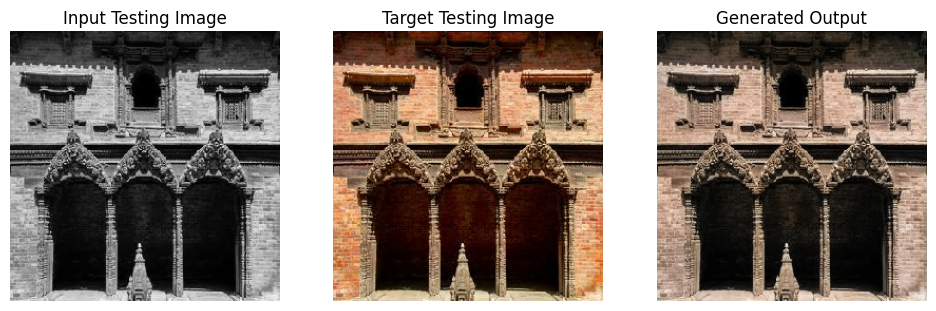

SSIM Score: 0.87701016664505
PSNR Score: 24.488239288330078
Epoch 51
Training Details
Generator-- total_loss:3.09 gan_loss:0.01 l1_loss:0.03 Discriminator-- total_loss:9.81 real_loss:9.81 generated_loss:0.00 --- SSIM 0.96 PSNR 25.62
Time taken for epoch 52 is 102.38654613494873 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.62 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:12.62 real_loss:12.61 generated_loss:0.00 --- SSIM 0.95 PSNR 24.77
Time taken for epoch 52 is 115.23391079902649 sec
Number of iteration {d} 70
Epoch 52
Training Details
Generator-- total_loss:3.09 gan_loss:0.01 l1_loss:0.03 Discriminator-- total_loss:10.17 real_loss:10.17 generated_loss:0.00 --- SSIM 0.96 PSNR 25.61
Time taken for epoch 53 is 103.14179134368896 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.60 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:12.78 real_loss:12.77 generated_loss:0.00 --- SSIM 0.95 PSNR 24.82
Time taken for epoch 53 is 11

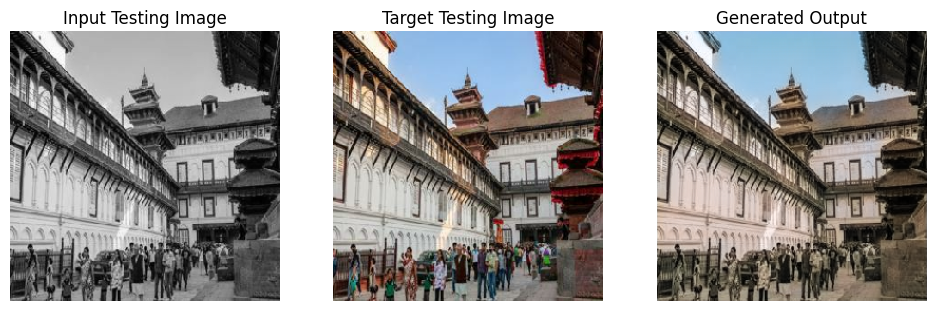

SSIM Score: 0.9724776148796082
PSNR Score: 27.563764572143555
Epoch 61
Training Details
Generator-- total_loss:13.07 gan_loss:10.00 l1_loss:0.03 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.96 PSNR 25.65
Time taken for epoch 62 is 110.3985447883606 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.82 gan_loss:0.21 l1_loss:0.04 Discriminator-- total_loss:2.71 real_loss:2.64 generated_loss:0.07 --- SSIM 0.95 PSNR 24.80
Time taken for epoch 62 is 123.22851705551147 sec
Number of iteration {d} 70
Epoch 62
Training Details
Generator-- total_loss:13.17 gan_loss:10.10 l1_loss:0.03 Discriminator-- total_loss:0.00 real_loss:0.00 generated_loss:0.00 --- SSIM 0.96 PSNR 25.65
Time taken for epoch 63 is 110.53674387931824 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.77 gan_loss:0.16 l1_loss:0.04 Discriminator-- total_loss:2.76 real_loss:2.71 generated_loss:0.06 --- SSIM 0.95 PSNR 24.80
Time taken for epoch 63 is 123

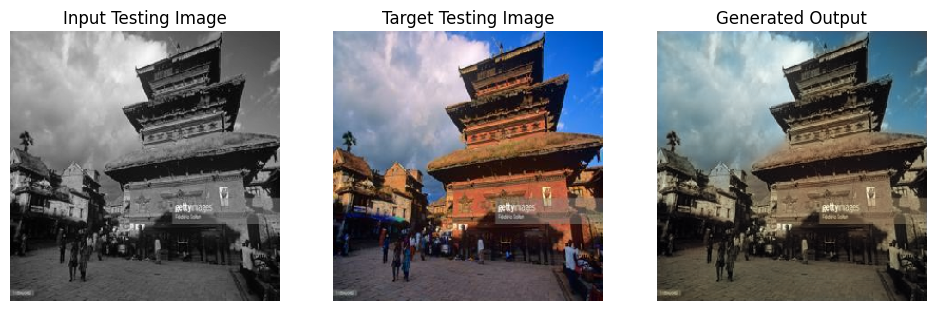

SSIM Score: 0.9356064796447754
PSNR Score: 21.83027458190918
Epoch 71
Training Details
Generator-- total_loss:3.15 gan_loss:0.01 l1_loss:0.03 Discriminator-- total_loss:14.41 real_loss:14.41 generated_loss:0.00 --- SSIM 0.95 PSNR 25.56
Time taken for epoch 72 is 103.44134378433228 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.69 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:13.99 real_loss:13.99 generated_loss:0.00 --- SSIM 0.95 PSNR 24.69
Time taken for epoch 72 is 116.50700759887695 sec
Number of iteration {d} 70
Reduced discriminator learning rate to 6.25000029685907e-05 at epoch 72.
Epoch 72
Training Details
Generator-- total_loss:11.74 gan_loss:8.61 l1_loss:0.03 Discriminator-- total_loss:0.12 real_loss:0.09 generated_loss:0.03 --- SSIM 0.95 PSNR 25.59
Time taken for epoch 73 is 112.2769820690155 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:4.03 gan_loss:0.35 l1_loss:0.04 Discriminator-- total_loss:2.09 real_loss:1.95 ge

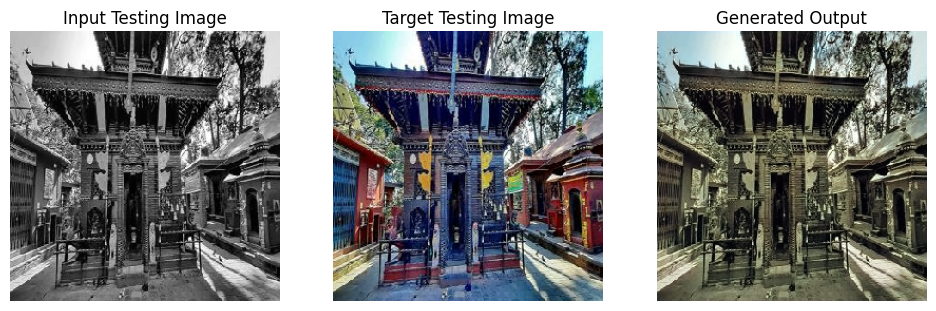

SSIM Score: 0.9322665333747864
PSNR Score: 21.228588104248047
Epoch 81
Training Details
Generator-- total_loss:4.15 gan_loss:0.79 l1_loss:0.03 Discriminator-- total_loss:2.52 real_loss:2.52 generated_loss:0.00 --- SSIM 0.93 PSNR 24.98
Time taken for epoch 82 is 103.29922938346863 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.97 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:8.76 real_loss:8.76 generated_loss:0.00 --- SSIM 0.95 PSNR 24.03
Time taken for epoch 82 is 116.29689073562622 sec
Number of iteration {d} 70
Epoch 82
Training Details
Generator-- total_loss:3.76 gan_loss:0.37 l1_loss:0.03 Discriminator-- total_loss:3.68 real_loss:3.68 generated_loss:0.00 --- SSIM 0.93 PSNR 24.90
Time taken for epoch 83 is 102.7196102142334 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.98 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:9.09 real_loss:9.09 generated_loss:0.00 --- SSIM 0.95 PSNR 24.00
Time taken for epoch 83 is 115.536

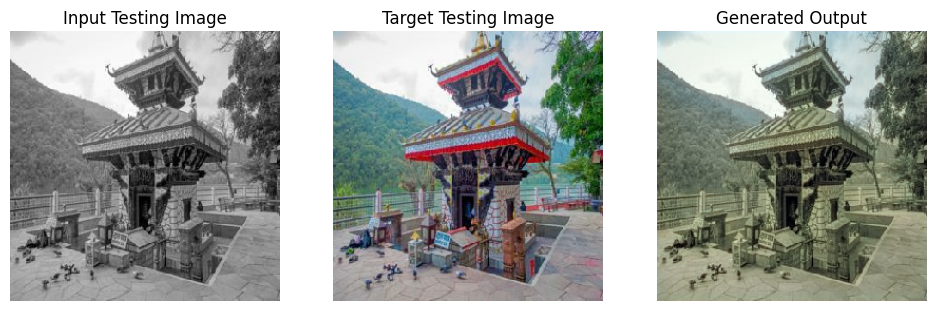

SSIM Score: 0.9364681839942932
PSNR Score: 22.599790573120117
Epoch 91
Training Details
Generator-- total_loss:3.48 gan_loss:0.05 l1_loss:0.03 Discriminator-- total_loss:6.86 real_loss:6.86 generated_loss:0.00 --- SSIM 0.92 PSNR 24.79
Time taken for epoch 92 is 103.04858136177063 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:3.96 gan_loss:0.00 l1_loss:0.04 Discriminator-- total_loss:10.09 real_loss:10.09 generated_loss:0.00 --- SSIM 0.94 PSNR 24.00
Time taken for epoch 92 is 116.13491559028625 sec
Number of iteration {d} 70
Reduced discriminator learning rate to 3.125000148429535e-05 at epoch 92.
Epoch 92
Training Details
Generator-- total_loss:10.70 gan_loss:7.27 l1_loss:0.03 Discriminator-- total_loss:0.10 real_loss:0.07 generated_loss:0.03 --- SSIM 0.92 PSNR 24.80
Time taken for epoch 93 is 111.78435707092285 sec
Number of iteration {d} 245
Testing Details
Generator-- total_loss:4.75 gan_loss:0.78 l1_loss:0.04 Discriminator-- total_loss:1.77 real_loss:1.42 g

In [40]:
fit(train_dataset, epochs, test_dataset, gen)

In [41]:
import csv
with open('/kaggle/working/dataJan18.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [42]:
os.mkdir('/kaggle/working/modelsJan18')

In [43]:
gen.save('/kaggle/working/modelsJan18/gen.h5')
gen.save_weights('/kaggle/working/modelsJan18/gen.keras')
disc.save('/kaggle/working/modelsJan18/disc.h5')
disc.save_weights('/kaggle/working/modelsJan18/disc.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [45]:
import subprocess
from IPython.display import FileLink, display

In [46]:
download_file('/kaggle/working', 'output')

/kaggle/working/output.zip